## Introduction to generative adversarial networks
### Getting our hands on the CelebA dataset
**Getting the CelebA data**

In [2]:
!mkdir celeba_gan
!gdown --id 1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684 -O celeba_gan/data.zip
!unzip -qq celeba_gan/data.zip -d celeba_gan

/bin/bash: /home/mengxiang/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
mkdir: cannot create directory ‘celeba_gan’: File exists
/bin/bash: /home/mengxiang/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/mengxiang/miniconda3/envs/tf-py38/lib/python3.8/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684
From (redirected): https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684&confirm=t&uuid=e7d31a9f-3455-44cb-8272-f6b3b91842f5
To: /home/mengxiang/Documents/GitHub/CSEN-5350-Application-of-Neural-Networks/gan/celeba_gan/data.zip
100%|██████████████████████████████████████| 1.44G/1.44G [03:00<00:00, 7.99MB/s]
/bin/bash: /home/mengxiang/miniconda3/lib/libtinfo.so.6

**Creating a dataset from a directory of images**

In [3]:
from tensorflow import keras
dataset = keras.utils.image_dataset_from_directory(
    "celeba_gan",
    label_mode=None,
    image_size=(64, 64),
    batch_size=32,
    smart_resize=True)

2023-05-07 21:44:49.992715: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-07 21:44:50.143594: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Found 202599 files belonging to 1 classes.


2023-05-07 21:44:54.268992: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-07 21:44:54.282786: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-07 21:44:54.282867: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-07 21:44:54.283907: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuil

**Rescaling the images**

In [4]:
dataset = dataset.map(lambda x: x / 255.)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


**Displaying the first image**

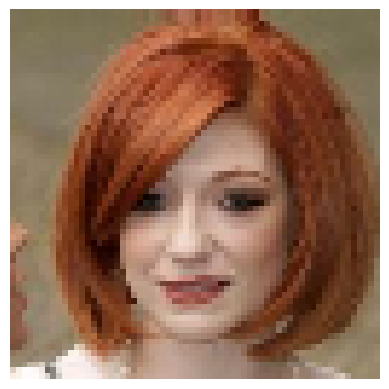

In [5]:
import matplotlib.pyplot as plt
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

### The discriminator
**The GAN discriminator network**

In [6]:
from tensorflow.keras import layers

discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

In [7]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

### The generator
**GAN generator network**

In [8]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [9]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

### The adversarial network
**The GAN `Model`**

In [10]:
import tensorflow as tf
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0
        )
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}

**A callback that samples generated images during training**

In [11]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")

**Compiling and training the GAN**

In [12]:
epochs = 100

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/100


2023-05-07 21:49:01.110855: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-07 21:49:01.629558: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-05-07 21:49:03.018316: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f54e41d1190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-07 21:49:03.018336: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-05-07 21:49:03.027959: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-07 21:49:03.144455: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of 

6332/6332 [==============================] - 490s 77ms/step - d_loss: 0.5991 - g_loss: 1.2758
Epoch 2/100
6332/6332 [==============================] - 486s 77ms/step - d_loss: 0.6490 - g_loss: 1.1054
Epoch 3/100
6332/6332 [==============================] - 477s 75ms/step - d_loss: 0.6569 - g_loss: 1.0489
Epoch 4/100
6332/6332 [==============================] - 475s 75ms/step - d_loss: 0.6468 - g_loss: 1.0760
Epoch 5/100
6332/6332 [==============================] - 484s 76ms/step - d_loss: 0.6425 - g_loss: 1.0569
Epoch 6/100
6332/6332 [==============================] - 474s 75ms/step - d_loss: 0.6555 - g_loss: 0.9681
Epoch 7/100
6332/6332 [==============================] - 482s 76ms/step - d_loss: 0.6723 - g_loss: 0.9266
Epoch 8/100
6332/6332 [==============================] - 483s 76ms/step - d_loss: 0.6768 - g_loss: 0.9013
Epoch 9/100
6332/6332 [==============================] - 483s 76ms/step - d_loss: 0.6872 - g_loss: 0.8643
Epoch 10/100
6332/6332 [==============================] - 

In [13]:
gan.history